# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

# Developed by :

# Riddhi Tokdar

In [2]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

In [3]:

import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [5]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
#batch_size = #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
def generator(source_path, folder_list, batch_size):
    #print("\n running generator ")
    #print( '\n Source path = ', source_path, '\n batch size =', batch_size )
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    #print("\n img_idx =" , img_idx)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        #print("\n num_batches =" , num_batches)
        for batch in range(num_batches): # we iterate over the number of batches
            #print("\n Processing batch = ", batch) 
            #print("\n batch: ",batch)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                #print("\n reading folder =", imgs)
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    image_resized = resize(image,(y,z))
                    image_resized = image_resized/255 #(image_resized - image_resized.min())/(image_resized.max() - image_resized.min())
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            #print("\n Processing batch left after full batches" ,   )
            
            batch_size = len(folder_list) - (batch_size*num_batches)
            #print("\n batch_size: ", batch_size)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                #print("\n reading folder =", imgs)
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized = resize(image,(y,z))  # resize the image 
                    image_resized = image_resized/255 # Normalize the image 

                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)
batch_size = 25
print ('# batch size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch size = 25


## Model 
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here

# Sample Model

- image height: 80

- image widht: 80

- filter: (3,3,3)

- batch size: 25

- epochs: 20

- number of frames : 20

In [9]:
x=20 # number of frames
y=80 #height
z=80 #width

#write your model here
Input_shape = (x, y, z, 3)
filtersize=(3,3,3)


model = Sequential()
model.add(Conv3D(16, filtersize, padding='same',input_shape=Input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())



model.add(Dropout(0.5))
model.add(Dense(5,activation='softmax'))

In [7]:
import tensorflow as tf
print(tf.__version__)

2.3.1


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [10]:
optimiser = tf.keras.optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 80, 80, 16)    1312      
_________________________________________________________________
activation (Activation)      (None, 20, 80, 80, 16)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 80, 80, 16)    64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 40, 40, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 40, 40, 32)    13856     
_________________________________________________________________
activation_1 (Activation)    (None, 10, 40, 40, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 40, 40, 32)    1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [16]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',period = 1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [17]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [18]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 1.7771 - categorical_accuracy: 0.3861
Epoch 00001: saving model to model_init_2021-11-3007_59_20.227462/model-00001-1.77705-0.38612-1.95333-0.22000.h5
27/27 [==============================] - 104s 4s/step - loss: 1.7771 - categorical_accuracy: 0.3861 - val_loss: 1.9533 - val_categorical_accuracy: 0.2200
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 1.3291 - categorical_accuracy: 0.4929
Epoch 00002: saving model to model_init_2021-11-3007_59_20.227462/model-00002-1.32907-0.49288-3.79302-0.16000.h5
27/27 [==============================] - 67s 2s/step - loss: 1.3291 - categorical_accuracy: 0.4929 - val_loss: 3.7930 - val_categorical_accuracy: 0.1600
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 1.3171 - categorical_accuracy: 0.4587
Epoch 00003: saving model to model_init_2021-11-3007_59_20.227462/model-00003-1.31708-0.45869-4.67324-0.16000.h5
27/27 [=============================

In [11]:
#function to plot accuracy
def plot_score(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

The previous model overfits. We'd try by increasing batch sizem image size

## Model 1:

- Number of Frames: 30
- Number of epochs: 15
- Batch Size: 30
- Image Size: (100,100,3)


In [20]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15
print ('# epochs =', num_epochs)
batch_size = 30
print ('# batch size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 15
# batch size = 30


In [21]:
x=30 # number of frames
y=100 #height
z=100 #width

#write your model here
Input_shape = (x, y, z, 3)
filtersize=(3,3,3)


model = Sequential()
model.add(Conv3D(16, filtersize, padding='same',input_shape=Input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())



model.add(Dropout(0.5))
model.add(Dense(5,activation='softmax'))

In [22]:
optimiser = tf.keras.optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 100, 100, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 30, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 50, 50, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 50, 50, 32)    13856     
_________________________________________________________________
activation_5 (Activation)    (None, 15, 50, 50, 32)    0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 50, 50, 32)   

In [23]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',period = 1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [24]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [25]:
model1=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 1.7131 - categorical_accuracy: 0.3779
Epoch 00001: saving model to model_init_2021-11-3008_24_54.951713/model-00001-1.71314-0.37793-1.66198-0.25000.h5
23/23 [==============================] - 61s 3s/step - loss: 1.7131 - categorical_accuracy: 0.3779 - val_loss: 1.6620 - val_categorical_accuracy: 0.2500
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 1.5325 - categorical_accuracy: 0.4247
Epoch 00002: saving model to model_init_2021-11-3008_24_54.951713/model-00002-1.53251-0.42475-2.93470-0.23000.h5
23/23 [==============================] - 61s 3s/step - loss: 1.5325 - categorical_accuracy: 0.4247 - val_loss: 2.9347 - val_categorical_accuracy: 0.2300
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 1.2367 - categorical_accuracy: 0.5385
Epoch 00003: saving model to model_init_2021-11-3008_24_54.951713/model-00003-1.23673-0.53846-5.15982-0.26000.h5
23/23 [==============================

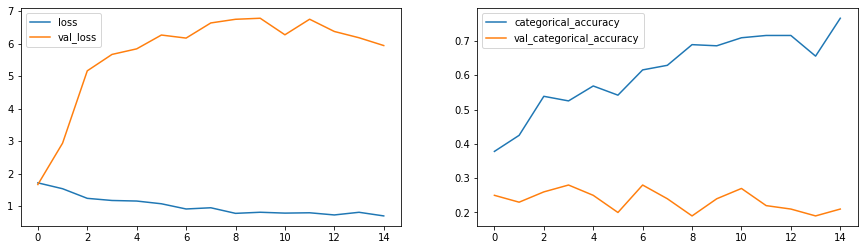

In [29]:
plot_score(model1)

# Model 2:
- Increasing figure size
- Number of epochs = 20
- Frames = 30
- Batch size = 20

In [36]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)
batch_size = 20
print ('# batch size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch size = 20


In [37]:
x=30 # number of frames
y=120 #height
z=120 #width

#write your model here
Input_shape = (x, y, z, 3)
filtersize=(3,3,3)


model = Sequential()
model.add(Conv3D(16, filtersize, padding='same',input_shape=Input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())



model.add(Dropout(0.5))
model.add(Dense(5,activation='softmax'))

In [38]:
optimiser = tf.keras.optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_12 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_13 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 15, 60, 60, 32)   

In [39]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',period = 1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [40]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [41]:
model2=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.5860 - categorical_accuracy: 0.4842
Epoch 00001: saving model to model_init_2021-11-3009_11_55.478589/model-00001-1.58595-0.48416-3.46326-0.17600.h5
34/34 [==============================] - 88s 3s/step - loss: 1.5860 - categorical_accuracy: 0.4842 - val_loss: 3.4633 - val_categorical_accuracy: 0.1760
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.2306 - categorical_accuracy: 0.5317
Epoch 00002: saving model to model_init_2021-11-3009_11_55.478589/model-00002-1.23058-0.53167-5.28290-0.16800.h5
34/34 [==============================] - 85s 3s/step - loss: 1.2306 - categorical_accuracy: 0.5317 - val_loss: 5.2829 - val_categorical_accuracy: 0.1680
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9003 - categorical_accuracy: 0.6448
Epoch 00003: saving model to model_init_2021-11-3009_11_55.478589/model-00003-0.90033-0.64480-7.96588-0.24000.h5
34/34 [==============================

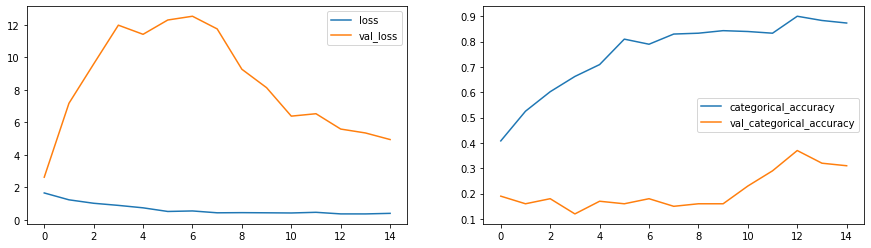

In [35]:
plot_score(model2)

# Model 3:
- Increasing number of layers
- Number of epochs = 25
- Frames = 20
- Batch size = 40

In [61]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25
print ('# epochs =', num_epochs)
batch_size = 40
print ('# batch size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 25
# batch size = 40


In [62]:
x=20 # number of frames
y=120 #height
z=120 #width

#write your model here
Input_shape = (x, y, z, 3)
filtersize=(3,3,3)


model = Sequential()
model.add(Conv3D(16, filtersize, padding='same',input_shape=Input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())



model.add(Conv3D(16, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())


model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())


model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [63]:
optimiser = tf.keras.optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_36 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_36 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
conv3d_37 (Conv3D)           (None, 20, 120, 120, 16)  6928      
_________________________________________________________________
activation_37 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_28 (MaxPooling (None, 10, 60, 60, 16)   

In [64]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',period = 1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [65]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [66]:
model3=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/25
17/17 [==============================] - ETA: 0s - loss: 1.9923 - categorical_accuracy: 0.3348
Epoch 00001: saving model to model_init_2021-11-3011_05_41.002705/model-00001-1.99229-0.33484-1.71463-0.22667.h5
17/17 [==============================] - 41s 2s/step - loss: 1.9923 - categorical_accuracy: 0.3348 - val_loss: 1.7146 - val_categorical_accuracy: 0.2267
Epoch 2/25
17/17 [==============================] - ETA: 0s - loss: 1.4841 - categorical_accuracy: 0.4525
Epoch 00002: saving model to model_init_2021-11-3011_05_41.002705/model-00002-1.48408-0.45249-1.84747-0.21333.h5
17/17 [==============================] - 39s 2s/step - loss: 1.4841 - categorical_accuracy: 0.4525 - val_loss: 1.8475 - val_categorical_accuracy: 0.2133
Epoch 3/25
17/17 [==============================] - ETA: 0s - loss: 1.4682 - categorical_accuracy: 0.4661
Epoch 00003: saving model to model_init_2021-11-3011_05_41.002705/model-00003-1.46815-0.46606-2.07620-0.24000.h5
17/17 [==============================

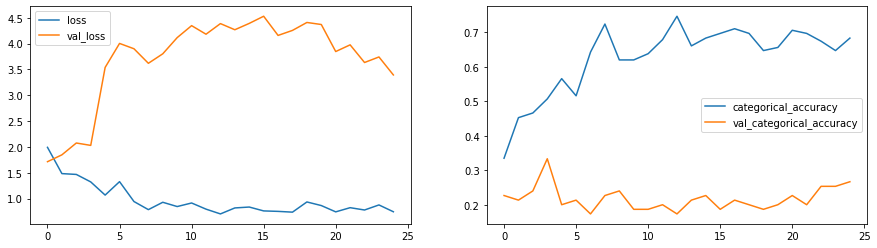

In [67]:
plot_score(model3)

# Model 4:

- Number of epochs = 20
- Frames = 30
- Batch size = 25
- Image Size= (80,80,3)

In [73]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)
batch_size = 25
print ('# batch size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch size = 25


In [76]:
x=30 # number of frames
y=80 #height
z=80 #width

#write your model here
Input_shape = (x, y, z, 3)
filtersize=(3,3,3)


model = Sequential()
model.add(Conv3D(16, filtersize, padding='same',input_shape=Input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())



model.add(Conv3D(16, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv3D(32, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.5))

model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())


model.add(Conv3D(64, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.5))

model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())


model.add(Conv3D(128, filtersize, padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5,activation='softmax'))

In [77]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_68 (Conv3D)           (None, 30, 80, 80, 16)    1312      
_________________________________________________________________
activation_68 (Activation)   (None, 30, 80, 80, 16)    0         
_________________________________________________________________
batch_normalization_85 (Batc (None, 30, 80, 80, 16)    64        
_________________________________________________________________
conv3d_69 (Conv3D)           (None, 30, 80, 80, 16)    6928      
_________________________________________________________________
activation_69 (Activation)   (None, 30, 80, 80, 16)    0         
_________________________________________________________________
batch_normalization_86 (Batc (None, 30, 80, 80, 16)    64        
_________________________________________________________________
max_pooling3d_44 (MaxPooling (None, 15, 40, 40, 16)  

In [78]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',period = 1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [79]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [80]:
model4=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 2.6683 - categorical_accuracy: 0.2051
Epoch 00001: saving model to model_init_2021-11-3011_24_28.761736/model-00001-2.66831-0.20513-1.61655-0.21000.h5
27/27 [==============================] - 57s 2s/step - loss: 2.6683 - categorical_accuracy: 0.2051 - val_loss: 1.6166 - val_categorical_accuracy: 0.2100
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 2.3075 - categorical_accuracy: 0.3020
Epoch 00002: saving model to model_init_2021-11-3011_24_28.761736/model-00002-2.30752-0.30199-1.77557-0.16000.h5
27/27 [==============================] - 60s 2s/step - loss: 2.3075 - categorical_accuracy: 0.3020 - val_loss: 1.7756 - val_categorical_accuracy: 0.1600
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 2.3258 - categorical_accuracy: 0.2906
Epoch 00003: saving model to model_init_2021-11-3011_24_28.761736/model-00003-2.32578-0.29060-1.89610-0.25000.h5
27/27 [==============================

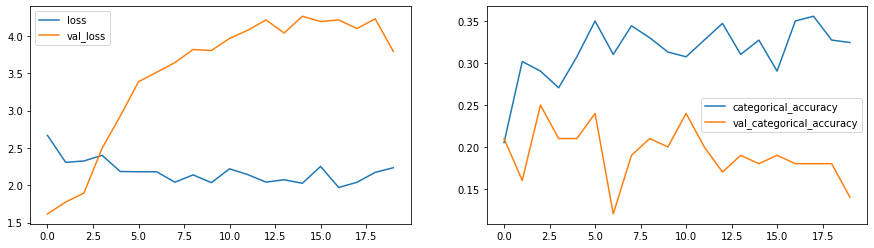

In [81]:
plot_score(model4)

# Model 5 :
# CNN + LSTM

In [12]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)
batch_size = 25
print ('# batch size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 30
# batch size = 25


In [13]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM , GRU
from tensorflow.keras.layers import TimeDistributed

In [14]:
x=20 # number of frames
y=120 #height
z=120 #width
lstm_cells=128
#write your model here
Input_shape = (x, y, z, 3)


model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=Input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))



model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))


model.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))



model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

model.add(TimeDistributed(Flatten()))

model.add(LSTM(lstm_cells))
model.add(Dropout(0.25))


model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))


        
model.add(Dense(5, activation='softmax'))

In [15]:
optimiser = tf.keras.optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 30, 30, 64)    1

In [16]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',period = 1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [17]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [18]:
lstm_model_1=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
27/27 [==============================] - ETA: 0s - loss: 1.4870 - categorical_accuracy: 0.3394
Epoch 00001: saving model to model_init_2021-11-3012_12_29.354555/model-00001-1.48705-0.33937-1.71144-0.17000.h5
27/27 [==============================] - 96s 4s/step - loss: 1.4870 - categorical_accuracy: 0.3394 - val_loss: 1.7114 - val_categorical_accuracy: 0.1700
Epoch 2/30
27/27 [==============================] - ETA: 0s - loss: 1.3223 - categorical_accuracy: 0.4359
Epoch 00002: saving model to model_init_2021-11-3012_12_29.354555/model-00002-1.32230-0.43590-1.62277-0.18000.h5
27/27 [==============================] - 60s 2s/step - loss: 1.3223 - categorical_accuracy: 0.4359 - val_loss: 1.6228 - val_categorical_accuracy: 0.1800
Epoch 3/30
27/27 [==============================] - ETA: 0s - loss: 1.2488 - categorical_accuracy: 0.4587
Epoch 00003: saving model to model_init_2021-11-3012_12_29.354555/model-00003-1.24882-0.45869-1.67470-0.21000.h5
27/27 [==============================

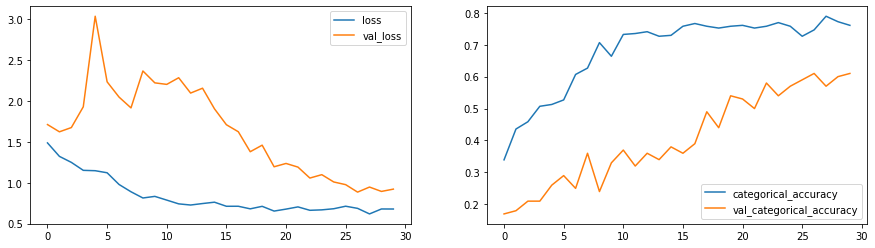

In [19]:
plot_score(lstm_model_1)

# Model 6:
CNN + LSTM

- reduce image size
- increase frame
- increase batch size
- fix learning rate
- increase drop out percentage

In [33]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)
batch_size = 35
print ('# batch size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch size = 35


In [34]:
x=30 # number of frames
y=160 #height
z=160 #width
lstm_cells=128
#write your model here
Input_shape = (x, y, z, 3)


model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=Input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))



model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))


model.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))



model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

model.add(TimeDistributed(Flatten()))

model.add(LSTM(lstm_cells))
model.add(Dropout(0.25))


model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))


        
model.add(Dense(5, activation='softmax'))

In [35]:
optimiser = tf.keras.optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_52 (TimeDis (None, 30, 160, 160, 16)  448       
_________________________________________________________________
time_distributed_53 (TimeDis (None, 30, 160, 160, 16)  64        
_________________________________________________________________
time_distributed_54 (TimeDis (None, 30, 80, 80, 16)    0         
_________________________________________________________________
time_distributed_55 (TimeDis (None, 30, 80, 80, 32)    4640      
_________________________________________________________________
time_distributed_56 (TimeDis (None, 30, 80, 80, 32)    128       
_________________________________________________________________
time_distributed_57 (TimeDis (None, 30, 40, 40, 32)    0         
_________________________________________________________________
time_distributed_58 (TimeDis (None, 30, 40, 40, 64)   

In [36]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',period = 1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [37]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [38]:
lstm_model2=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
19/19 [==============================] - ETA: 0s - loss: 1.8203 - categorical_accuracy: 0.2024
Epoch 00001: saving model to model_init_2021-11-3013_22_15.825574/model-00001-1.82030-0.20243-1.72073-0.18667.h5
19/19 [==============================] - 51s 3s/step - loss: 1.8203 - categorical_accuracy: 0.2024 - val_loss: 1.7207 - val_categorical_accuracy: 0.1867
Epoch 2/20
19/19 [==============================] - ETA: 0s - loss: 1.6802 - categorical_accuracy: 0.2591
Epoch 00002: saving model to model_init_2021-11-3013_22_15.825574/model-00002-1.68019-0.25911-1.67982-0.20000.h5
19/19 [==============================] - 50s 3s/step - loss: 1.6802 - categorical_accuracy: 0.2591 - val_loss: 1.6798 - val_categorical_accuracy: 0.2000
Epoch 3/20
19/19 [==============================] - ETA: 0s - loss: 1.7076 - categorical_accuracy: 0.1984
Epoch 00003: saving model to model_init_2021-11-3013_22_15.825574/model-00003-1.70763-0.19838-1.58354-0.21333.h5
19/19 [==============================

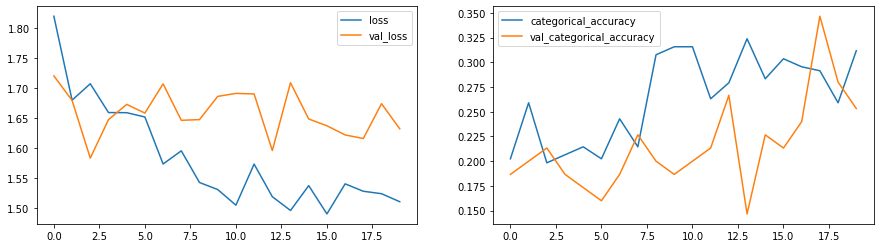

In [40]:
plot_score(lstm_model2)

# Model 7 :
# CNN + LSTM
- Lower batch size
- increase epochs
- lower image size

In [41]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 40
print ('# epochs =', num_epochs)
batch_size = 30
print ('# batch size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 40
# batch size = 30


In [42]:
x=25 # number of frames
y=120 #height
z=120 #width
lstm_cells=128
#write your model here
Input_shape = (x, y, z, 3)


model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=Input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))



model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))


model.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))



model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

model.add(TimeDistributed(Flatten()))

model.add(LSTM(lstm_cells))
model.add(Dropout(0.25))


model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))


        
model.add(Dense(5, activation='softmax'))

In [43]:
optimiser = tf.keras.optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_65 (TimeDis (None, 25, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_66 (TimeDis (None, 25, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_67 (TimeDis (None, 25, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_68 (TimeDis (None, 25, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_69 (TimeDis (None, 25, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_70 (TimeDis (None, 25, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_71 (TimeDis (None, 25, 30, 30, 64)   

In [44]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',period = 1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [45]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [46]:
lstm_model3=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/40
23/23 [==============================] - ETA: 0s - loss: 1.7051 - categorical_accuracy: 0.2207
Epoch 00001: saving model to model_init_2021-11-3013_41_06.030748/model-00001-1.70510-0.22074-1.67566-0.27000.h5
23/23 [==============================] - 52s 2s/step - loss: 1.7051 - categorical_accuracy: 0.2207 - val_loss: 1.6757 - val_categorical_accuracy: 0.2700
Epoch 2/40
23/23 [==============================] - ETA: 0s - loss: 1.6744 - categorical_accuracy: 0.1739
Epoch 00002: saving model to model_init_2021-11-3013_41_06.030748/model-00002-1.67440-0.17391-1.81584-0.15000.h5
23/23 [==============================] - 54s 2s/step - loss: 1.6744 - categorical_accuracy: 0.1739 - val_loss: 1.8158 - val_categorical_accuracy: 0.1500
Epoch 3/40
23/23 [==============================] - ETA: 0s - loss: 1.5746 - categorical_accuracy: 0.2609
Epoch 00003: saving model to model_init_2021-11-3013_41_06.030748/model-00003-1.57455-0.26087-1.79739-0.18000.h5
23/23 [==============================

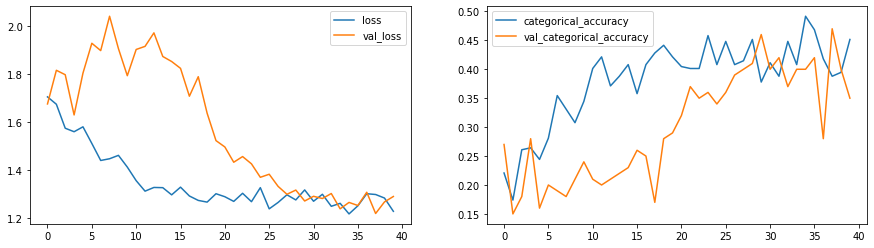

In [47]:
plot_score(lstm_model3)

# Model 8 :
# CNN + LSTM
- Batch size = 25
- Epochs = 50
- Frames = 20
- Image size = (120,120,3)

In [48]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50
print ('# epochs =', num_epochs)
batch_size = 25
print ('# batch size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 50
# batch size = 25


In [49]:
x=20 # number of frames
y=120 #height
z=120 #width
lstm_cells=128
#write your model here
Input_shape = (x, y, z, 3)


model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=Input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))



model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))


model.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))



model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

model.add(TimeDistributed(Flatten()))

model.add(LSTM(lstm_cells))
model.add(Dropout(0.25))


model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))


        
model.add(Dense(5, activation='softmax'))

In [50]:
optimiser = tf.keras.optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_78 (TimeDis (None, 20, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_79 (TimeDis (None, 20, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_80 (TimeDis (None, 20, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_81 (TimeDis (None, 20, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_82 (TimeDis (None, 20, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_83 (TimeDis (None, 20, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_84 (TimeDis (None, 20, 30, 30, 64)   

In [51]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',period = 1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [52]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [53]:
lstm_model4=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
27/27 [==============================] - ETA: 0s - loss: 1.5869 - categorical_accuracy: 0.3020
Epoch 00001: saving model to model_init_2021-11-3014_19_43.420115/model-00001-1.58689-0.30199-1.68747-0.08000.h5
27/27 [==============================] - 60s 2s/step - loss: 1.5869 - categorical_accuracy: 0.3020 - val_loss: 1.6875 - val_categorical_accuracy: 0.0800
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 1.3773 - categorical_accuracy: 0.4330
Epoch 00002: saving model to model_init_2021-11-3014_19_43.420115/model-00002-1.37727-0.43305-1.62088-0.26000.h5
27/27 [==============================] - 64s 2s/step - loss: 1.3773 - categorical_accuracy: 0.4330 - val_loss: 1.6209 - val_categorical_accuracy: 0.2600
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 1.1875 - categorical_accuracy: 0.5271
Epoch 00003: saving model to model_init_2021-11-3014_19_43.420115/model-00003-1.18749-0.52707-1.72464-0.21000.h5
27/27 [==============================

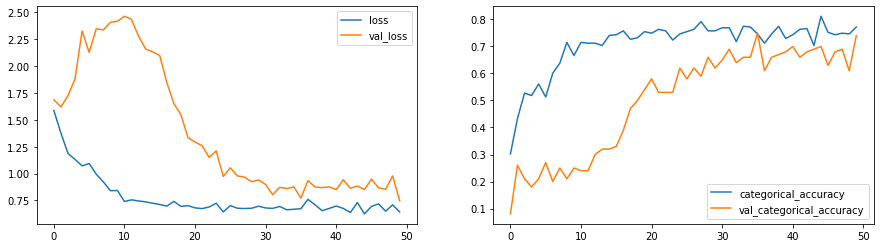

In [54]:
plot_score(lstm_model4)